##### Mediapipe 人臉特徵點偵測 ( Face Landmark Detection )
MediaPipe 的 Face Landmark Detection 可以在檢測人臉的特徵點，並將特徵點應用於識別表情、臉部濾鏡特效，以及建立虛擬頭像等等，\
這篇教學會介紹如何使用 Mediapipe 人臉特徵點偵測。

因為程式中的 OpenCV 會需要使用鏡頭或 GPU，所以請使用本機環境或使用 Anaconda Jupyter 進行實作，\
並安裝 OpenCV 函式庫 ( 參考：[OpenCV 函式庫](https://steam.oxxostudio.tw/category/python/ai/opencv.html) )。

##### 人臉特徵點是什麼？ 
MediaPipe 人臉特徵點偵測 ( Face Landmark Detection ) 使用機器學習模型，識別單張圖像或連續圖像的面部表情，並輸出三維的人臉特徵點，\
並將這些特徵點應用於識別表情、臉部濾鏡特效，以及建立虛擬頭像等等，此外，MediaPipe 還提供了不同的設定選項，方便開發者設置運行模式、\
檢測的臉部數量、面部的最小信心分數等。

Face Landmark Detection 提供三種模型來偵測：
* Face detection model ( 人臉偵測模型 )：偵測是否有人臉。
* Face mesh model ( 臉部網格模型 )：判斷人臉的表面和深度，透過 478 個臉部標記 ( 面部姿態變換矩陣、三角形面部網格...等 ) 畫出 3D 的人臉網格。
* Blendshape prediction model ( Blendshape 預測模型 )：接收臉部網格模型的輸出，預測 52 個 blendshape 分數，透過分數表現不同的臉部表情。

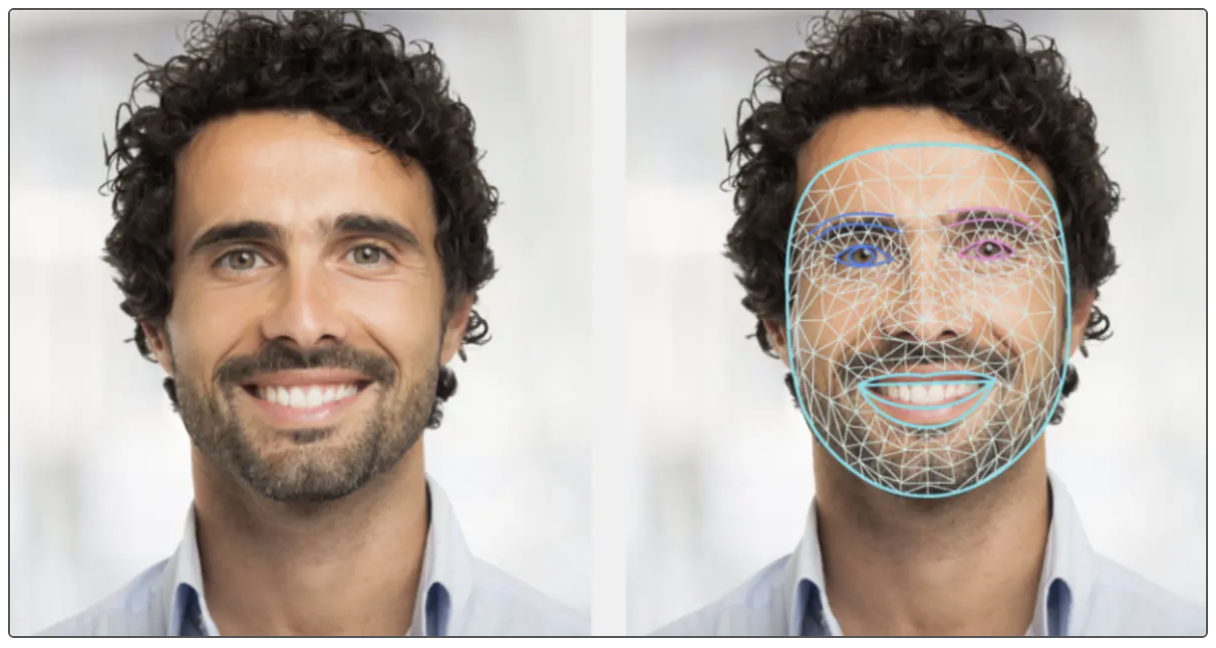

##### 繪製人臉網格 
在開發的資料夾裡新增一個 Python 檔案和一個名為 model 的資料夾，下載偵測模型 face_landmarker.task 放在 model 的資料夾中，輸入下方的程式碼，\
執行後就可以透過攝影機拍攝人臉，並會即時標記出人臉網格。

* 下載模型：[face_landmarker.task](https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/latest/face_landmarker.task)

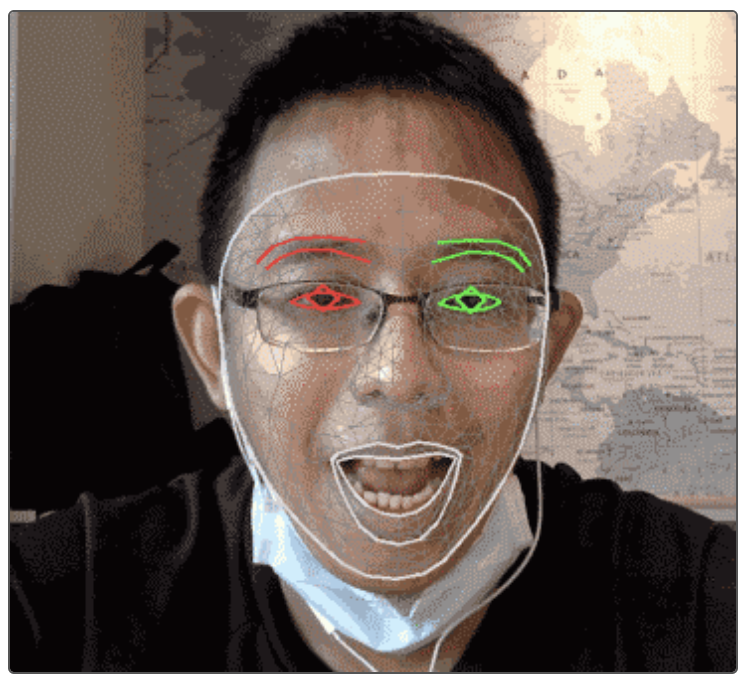

In [ ]:
import cv2
import numpy as np
import mediapipe as mp
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2

# 設定方法
BaseOptions = mp.tasks.BaseOptions  # 基本選項，用於設置模型路徑等基本配置
FaceLandmarker = mp.tasks.vision.FaceLandmarker  # 人臉特徵點偵測器類
FaceLandmarkerOptions = mp.tasks.vision.FaceLandmarkerOptions  # 人臉特徵點偵測器選項類
VisionRunningMode = mp.tasks.vision.RunningMode  # 視覺運行模式類

# 人臉偵測設定
options = FaceLandmarkerOptions(
    base_options=BaseOptions(model_asset_path=r'Model/15/face_landmarker.task'),  # 模型路徑
    running_mode=VisionRunningMode.IMAGE  # 運行模式設為處理單張圖片
)

# 執行人臉偵測
with FaceLandmarker.create_from_options(options) as landmarker:
    cap = cv2.VideoCapture(0)  # 讀取攝影鏡頭，參數 0 表示使用預設攝影機
    while True:
        ret, frame = cap.read()  # 讀取影片的每一幀
        if not ret:
            print("Cannot receive frame")  # 如果讀取錯誤，印出訊息
            break

        w = frame.shape[1]  # 畫面寬度
        h = frame.shape[0]  # 畫面高度
        mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame)  # 將影像轉換為 Mediapipe 格式
        face_landmarker_result = landmarker.detect(mp_image)  # 執行人臉偵測

        face_landmarks_list = face_landmarker_result.face_landmarks  # 獲取人臉特徵點列表
        annotated_image = np.copy(frame)  # 複製影像以進行標註

        # 遍歷偵測到的人臉以進行可視化
        for idx in range(len(face_landmarks_list)):
            face_landmarks = face_landmarks_list[idx]

            # 繪製人臉特徵點
            face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
            face_landmarks_proto.landmark.extend([
                landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in face_landmarks
            ])

            # 繪製人臉特徵點的三個不同部分：網格、輪廓和虹膜
            # 繪製人臉網格特徵點
            solutions.drawing_utils.draw_landmarks(
                image=annotated_image,  # 要在其上繪製特徵點的影像
                landmark_list=face_landmarks_proto,  # 人臉特徵點列表
                connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,  # 特徵點之間的連接關係，用於繪製網格
                landmark_drawing_spec=None,  # 特徵點的繪製規格，None 表示使用預設值
                connection_drawing_spec=mp.solutions.drawing_styles.get_default_face_mesh_tesselation_style()  # 連接線的繪製規格，使用預設的網格樣式
            )

            # 繪製人臉輪廓特徵點
            solutions.drawing_utils.draw_landmarks(
                image=annotated_image,  # 要在其上繪製特徵點的影像
                landmark_list=face_landmarks_proto,  # 人臉特徵點列表
                connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,  # 特徵點之間的連接關係，用於繪製輪廓
                landmark_drawing_spec=None,  # 特徵點的繪製規格，None 表示使用預設值
                connection_drawing_spec=mp.solutions.drawing_styles.get_default_face_mesh_contours_style()  # 連接線的繪製規格，使用預設的輪廓樣式
            )

            # 繪製人臉虹膜特徵點
            solutions.drawing_utils.draw_landmarks(
                image=annotated_image,  # 要在其上繪製特徵點的影像
                landmark_list=face_landmarks_proto,  # 人臉特徵點列表
                connections=mp.solutions.face_mesh.FACEMESH_IRISES,  # 特徵點之間的連接關係，用於繪製虹膜
                landmark_drawing_spec=None,  # 特徵點的繪製規格，None 表示使用預設值
                connection_drawing_spec=mp.solutions.drawing_styles.get_default_face_mesh_iris_connections_style()  # 連接線的繪製規格，使用預設的虹膜樣式
            )

        cv2.imshow('oxxostudio', annotated_image)  # 顯示標註後的影像
        if cv2.waitKey(10) == ord('q'):  # 每一毫秒更新一次，直到按下 q 結束
            break

    cap.release()  # 所有作業都完成後，釋放資源
    cv2.destroyAllWindows()  # 結束所有視窗

##### 繪製只有網格的人臉 
如果將原本攝影的畫面隱藏，就可以將產生的 3D 人臉網格套用在其他圖片裡，形成有趣的影像。

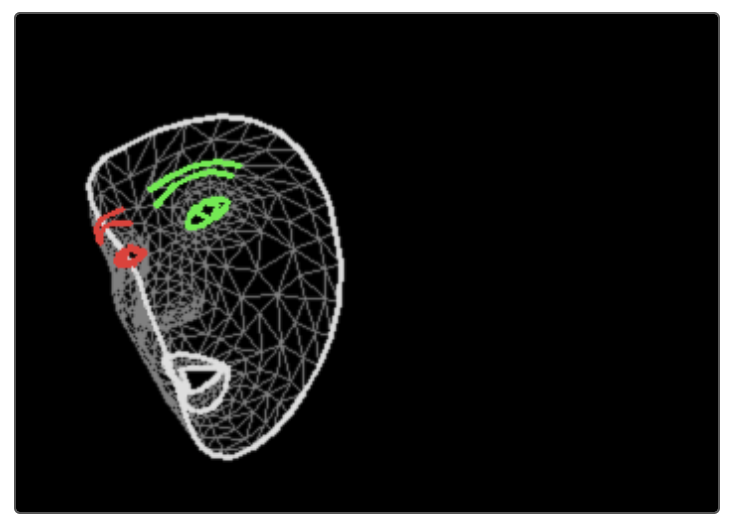

In [ ]:
import cv2
import numpy as np
import mediapipe as mp
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2

# 設定方法
BaseOptions = mp.tasks.BaseOptions  # 基本選項，用於設置模型路徑等基本配置
FaceLandmarker = mp.tasks.vision.FaceLandmarker  # 人臉特徵點偵測器類
FaceLandmarkerOptions = mp.tasks.vision.FaceLandmarkerOptions  # 人臉特徵點偵測器選項類
VisionRunningMode = mp.tasks.vision.RunningMode  # 視覺運行模式類

# 人臉偵測設定
options = FaceLandmarkerOptions(
    base_options=BaseOptions(model_asset_path=r'Model/15/face_landmarker.task'),  # 模型路徑
    running_mode=VisionRunningMode.IMAGE  # 運行模式設為處理單張圖片
)

# 執行人臉偵測
with FaceLandmarker.create_from_options(options) as landmarker:
    cap = cv2.VideoCapture(0)  # 讀取攝影鏡頭，參數 0 表示使用預設攝影機
    while True:
        ret, frame = cap.read()  # 讀取影片的每一幀
        if not ret:
            print("Cannot receive frame")  # 如果讀取錯誤，印出訊息
            break

        w = frame.shape[1]  # 畫面寬度
        h = frame.shape[0]  # 畫面高度
        img = cv2.resize(frame, (480, 320))  # 調整影像尺寸為 480x320
        output = np.zeros((320, 480, 3), dtype='uint8')  # 繪製 480x320 的黑色畫布
        img2 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # 轉換顏色
        mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=img2)  # 將影像轉換為 Mediapipe 格式
        face_landmarker_result = landmarker.detect(mp_image)  # 執行人臉偵測

        face_landmarks_list = face_landmarker_result.face_landmarks  # 獲取人臉特徵點列表
        annotated_image = np.copy(output)  # 複製影像以進行標註

        # 遍歷偵測到的人臉以進行可視化
        for idx in range(len(face_landmarks_list)):
            face_landmarks = face_landmarks_list[idx]

            # 繪製人臉特徵點
            face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
            face_landmarks_proto.landmark.extend([
                landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in face_landmarks
            ])

            # 繪製人臉網格特徵點
            solutions.drawing_utils.draw_landmarks(
                image=annotated_image,  # 要在其上繪製特徵點的影像
                landmark_list=face_landmarks_proto,  # 人臉特徵點列表
                connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,  # 特徵點之間的連接關係，用於繪製網格
                landmark_drawing_spec=None,  # 特徵點的繪製規格，None 表示使用預設值
                connection_drawing_spec=mp.solutions.drawing_styles.get_default_face_mesh_tesselation_style()  # 連接線的繪製規格，使用預設的網格樣式
            )

            # 繪製人臉輪廓特徵點
            solutions.drawing_utils.draw_landmarks(
                image=annotated_image,  # 要在其上繪製特徵點的影像
                landmark_list=face_landmarks_proto,  # 人臉特徵點列表
                connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,  # 特徵點之間的連接關係，用於繪製輪廓
                landmark_drawing_spec=None,  # 特徵點的繪製規格，None 表示使用預設值
                connection_drawing_spec=mp.solutions.drawing_styles.get_default_face_mesh_contours_style()  # 連接線的繪製規格，使用預設的輪廓樣式
            )

            # 繪製人臉虹膜特徵點
            solutions.drawing_utils.draw_landmarks(
                image=annotated_image,  # 要在其上繪製特徵點的影像
                landmark_list=face_landmarks_proto,  # 人臉特徵點列表
                connections=mp.solutions.face_mesh.FACEMESH_IRISES,  # 特徵點之間的連接關係，用於繪製虹膜
                landmark_drawing_spec=None,  # 特徵點的繪製規格，None 表示使用預設值
                connection_drawing_spec=mp.solutions.drawing_styles.get_default_face_mesh_iris_connections_style()  # 連接線的繪製規格，使用預設的虹膜樣式
            )

        cv2.imshow('oxxostudio', annotated_image)  # 顯示標註後的影像
        if cv2.waitKey(10) == ord('q'):  # 每一毫秒更新一次，直到按下 q 結束
            break

    cap.release()  # 所有作業都完成後，釋放資源
    cv2.destroyAllWindows()  # 結束所有視窗